Citation: Richardson G, Knudby A, Chen W, Sawada M, Lovitt J, He L, et al. (2023) Dense neural network outperforms other machine learning models for scaling-up lichen cover maps in Eastern Canada. PLoS ONE 18(11): e0292839. https://doi.org/10.1371/journal.pone.0292839

In [9]:
import numpy as np 
from pathlib import Path
import os, shutil, time, csv,math
from os import walk
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.dpi'] = 150 
%matplotlib inline

## Variables

In [2]:
#Full Image Folder Path
Top_dir = r'D:\Training_Data_Creation'
foldtypes=['Train','Test','Val']
#imgtypes=['123','456','789','m','class_m','binary_m'] #If using classified masks which we are not
imgtypes=['123','456','789','m']
megatile_size=[40,40]
#A list of all the Tilesizes which will be tested
Tilesize_list=[3,5,7]
#nodata value
NDV = [255, 255, 255] #no data value vound in mask images.

## Defining Initial Functions

In [17]:
def walk_and_create_MW_tiles(foldtype,Tilesize):
    for imgtype in imgtypes:
        imnum=0
        mega_dir='{}\\{}_Mega_{}\\Megatiles_{}\\'.format(Top_dir,foldtype,megatile_size[0],imgtype)
        tile_dir='{}\\{}_Tiles_ts{}-mega{}\\Tiles_{}\\'.format(Top_dir,foldtype,Tilesize,megatile_size[0],imgtype)
        if Path(tile_dir).exists()==False:
            os.makedirs(tile_dir)
        shutil.rmtree(tile_dir)
        os.makedirs(tile_dir)
        for (dirpath, dirnames, filenames) in walk(mega_dir):
            for subfile in filenames:
                img= cv2.imread(mega_dir+subfile,3)
                #want max range == megatilesize-tilesize+1 (lookup how range function works)
                for i in range((megatile_size[0]-Tilesize+1)):
                    for j in range((megatile_size[0]-Tilesize+1)):
                        #creating all the training images (15)
                        tile_img=img[i:i+Tilesize,j:j+Tilesize]
                        if imgtype[-1:]!='m':
                            sought = [0,0,0]
                        else:
                            sought = NDV
                        nd_pix = np.count_nonzero(tile_img==sought) #count all the nodata pixels
                        if nd_pix == 0: #we dont want any for this analysis
                            tile_name="{}_size{},{}".format(foldtype,Tilesize,str(imnum))
                            #determining image path for saving
                            #img_path=tile_dir +subfile[:-4]+ '{}.png'.format(tile_name) For adding megatile name to file path
                            img_path=tile_dir + '{}.png'.format(tile_name)
                            cv2.imwrite(img_path, tile_img)
                            imnum+=1
                        else:
                            continue
    print("{} Moving window tiles for {}, Tilesize: {}".format(imnum,foldtype,Tilesize))


In [18]:
def make_test_dsets_consistent(maxtilesize, currenttilesize):   
    for imgtype in imgtypes:
        imnumthree,imnumfive=0,0 #numbers for file saving
        maxtile_dir='{}\\Test_Tiles_ts{}-mega{}\\Tiles_{}\\'.format(Top_dir,maxtilesize,megatile_size[0],imgtype)
        currenttile_dir='{}\\Test_Tiles_ts{}-mega{}\\Tiles_{}\\'.format(Top_dir,currenttilesize,megatile_size[0],imgtype)
        if currenttilesize != maxtilesize: #clear exisitng test dataset of images to fill with new ones
            shutil.rmtree(currenttile_dir)
            os.makedirs(currenttile_dir)
        for (dirpath, dirnames, filenames) in walk(maxtile_dir):
            for subfile in filenames:
                img= cv2.imread(maxtile_dir+subfile,3)
                if currenttilesize == 3:
                    tile_img=img[2:5,2:5] #subset around middle pixel
                    tile_name="Test_size3,{}".format(str(imnumthree))
                    img_path=currenttile_dir + '{}.png'.format(tile_name)
                    cv2.imwrite(img_path, tile_img) #save new tile to currenttilesize dir
                    imnumthree+=1
                if currenttilesize == 5:
                    tile_img=img[1:6,1:6]#subset around middle pixel
                    tile_name="Test_size5,{}".format(str(imnumfive))
                    img_path=currenttile_dir + '{}.png'.format(tile_name)
                    cv2.imwrite(img_path, tile_img)
                    imnumfive+=1
    print('{} Tilesize Test dataset processed'.format(currenttilesize))
                    

## Process Data

In [19]:
for data_type in foldtypes:
    for size in Tilesize_list:
        walk_and_create_MW_tiles(data_type,size)


19594 Moving window tiles for Train, Tilesize: 3
15360 Moving window tiles for Train, Tilesize: 5
11621 Moving window tiles for Train, Tilesize: 7
6844 Moving window tiles for Test, Tilesize: 3
5310 Moving window tiles for Test, Tilesize: 5
3963 Moving window tiles for Test, Tilesize: 7
6276 Moving window tiles for Val, Tilesize: 3
4916 Moving window tiles for Val, Tilesize: 5
3718 Moving window tiles for Val, Tilesize: 7


In [20]:
'''Make test datasets consistent across tiles'''
for ts in Tilesize_list:
    make_test_dsets_consistent(7, ts)

3 Tilesize Test dataset processed
5 Tilesize Test dataset processed
7 Tilesize Test dataset processed


## Creating TF txt files

#### Centre pixel regression tile TXT files

In [22]:
#creating TXT files for training, testing, validation Middle pixel value
def create_midreg_tiles(i,Tilesize):
    l1,l2,l3,lm=[],[],[],[]
    for itype in imgtypes:
        subdir=Top_dir+'\\{}_Tiles_ts{}-mega{}\\Tiles_{}'.format(i,Tilesize,megatile_size[0],itype)
        for (dirpath, dirnames, filenames) in walk(subdir):
            for subfile in filenames:
                if itype == '123': #creating lists of where to get the images 
                    l1.append(subdir+'\\'+subfile)
                if itype == '456':
                    l2.append(subdir+'\\'+subfile)
                if itype == '789':
                    l3.append(subdir+'\\'+subfile)
                if itype == 'm':
                    img= cv2.imread(subdir+'\\'+subfile,3)
                    mid_pix=img[int(Tilesize/2-.5),int(Tilesize/2-.5)] #locating the midpixel value
                    value=mid_pix[0]
                    lm.append(value)
    total_list=[]
    print('txt file created on {} {} dataset with {} imgs and {} masks'.format(i,Tilesize,len(l1), len(lm)))
    for j in range (len(lm)):
        #create one list of lists which has all the paths
        entry='{} {} {} {}'.format(lm[j],l1[j],l2[j],l3[j])
        total_list.append(entry)
    label= Top_dir+'\\Pointer_files\\Midpix{}_ts{}-mega{}.txt'.format(i,Tilesize,megatile_size[0])
    with open(label, 'w') as f:
        #write each list as a word with a space in a txt
        for line in list(total_list):
            f.write(str(line))
            f.write('\n')

In [ ]:
for data_type in foldtypes:
    for size in Tilesize_list: 
        create_midreg_tiles(data_type,size)

txt file created on Train 3 dataset with 19594 imgs and 19594 masks
txt file created on Train 5 dataset with 15360 imgs and 15360 masks


In [23]:
create_midreg_tiles('TestEVAL',3)

txt file created on TestEVAL 3 dataset with 6844 imgs and 6844 masks


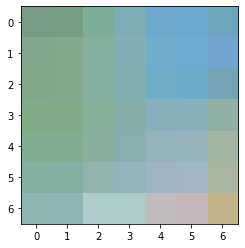

In [7]:
'''To show zooming in'''
img= cv2.imread(r'D:\Training_Data_Creation\Test_Tiles_ts7-mega40\Tiles_789\Test_size7,3.png',3)
plt.imshow(img/65535)
tile_img=img[1:6,1:6]
#plt.imshow(tile_img/65535)

In [20]:
def reformat_class_masks(foldtype,tiletype_list,masktype):
    '''Function which reformats the classified and binary masks into TF readable images.
    this script sets all NDV == 0 lichen, which shouldnt be common if you set the NDV threshold'''
    for tiletype in tiletype_list:
        tile_dir='{}\\{}_Tiles_ts{}-mega{}\\{}{}\\'.format(Top_dir,foldtype,Tilesize[0],megatile_size[0],tiletype,masktype)
        for (dirpath, dirnames, filenames) in walk(tile_dir):
            for subfile in filenames:
                img= cv2.imread(tile_dir+subfile,3)
                img_shape= img.shape
                Y,X = img_shape[0],img_shape[1]
                for i in range(Y):
                    for j in range (X):
                        if (img[i,j][0]==255): #if they are greater than threshold, set to 100,100,100
                            img[i,j]=[0,0,0]
                cv2.imwrite(tile_dir+subfile, img)
    print("{} masks reformatted for TF for {}".format(masktype,foldtype))

In [ ]:
Threshold_ND =0
#if set to 0 means that only complete images will be accepted.
#if set to 5 means that each tile can have upto 5 NDV pixels.
#if set to 25 (for 5x5 tiles), then tiles consising of all NDV will be accepted.

def walk_and_create_nonMW_tiles(foldtype):
    for imgtype in imgtypes:
        imnum=0
        mega_dir='{}\\{}_Mega_{}\\Megatiles_{}\\'.format(Top_dir,foldtype,megatile_size[0],imgtype)
        tile_dir='{}\\{}_Tiles_ts{}-mega{}\\Tiles_nonMW_{}\\'.format(Top_dir,foldtype,Tilesize[0],megatile_size[0],imgtype)
        if Path(tile_dir).exists()==False:
            os.makedirs(tile_dir)
        shutil.rmtree(tile_dir)
        os.makedirs(tile_dir)
        for (dirpath, dirnames, filenames) in walk(mega_dir):
            for subfile in filenames:
                img= cv2.imread(mega_dir+subfile,3)
                #dividing to get how many complete tiles fit into a megatile
                for i in range(int(megatile_size[0]/Tilesize[0])):
                    for j in range(int(megatile_size[0]/Tilesize[0])):
                        #creating all the training images (15)
                        it,jt=i*Tilesize[0],j*Tilesize[0] #it,jt stand for tile versions of the i,j variables. used to iterate.
                        tile_img=img[it:it+Tilesize[0],jt:jt+Tilesize[0]]
                        tile_name="{}_size{},{}".format(foldtype,Tilesize[0],str(imnum))
                        #determining image path for saving
                        if imgtype[-1:]!='m':
                            sought = [0,0,0]
                        else:
                            sought = NDV
                        nd_pix = np.count_nonzero(tile_img==sought)/3
                        #counts all instances of NDV in NParray, where pixels are [NDV,NDV,NDV]. That is why divide by 3.
                        if nd_pix <(Threshold_ND+1):#if there are less NDV pixels in the tile than threshold
                            tile_name="{}_size{},{}".format(foldtype,Tilesize[0],str(imnum))
                            #determining image path for saving
                            img_path=tile_dir + '{}.png'.format(tile_name)
                            cv2.imwrite(img_path, tile_img)
                            imnum+=1
    print("{} Non Moving Window tiles for {}".format(imnum,foldtype))

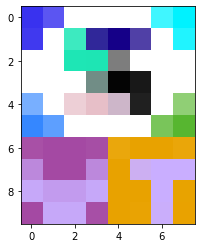

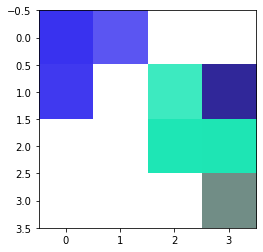

Number of white pix: 8


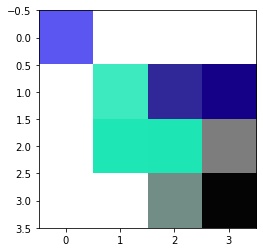

Number of white pix: 7
Image saved since below threshold


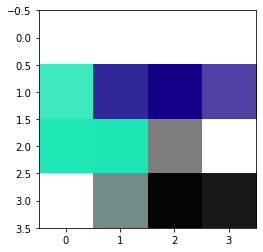

Number of white pix: 6
Image saved since below threshold


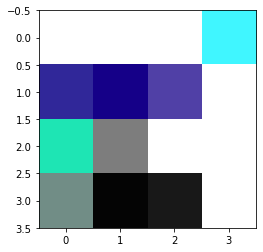

Number of white pix: 7
Image saved since below threshold


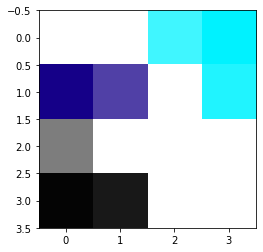

Number of white pix: 8


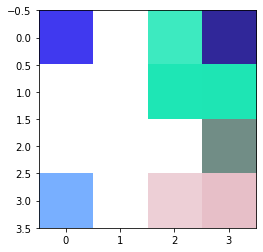

Number of white pix: 7
Image saved since below threshold


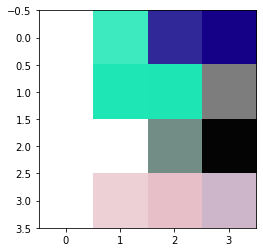

Number of white pix: 5
Image saved since below threshold


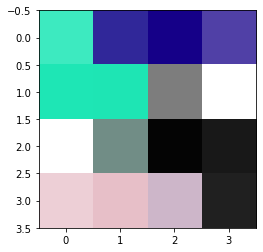

Number of white pix: 2
Image saved since below threshold


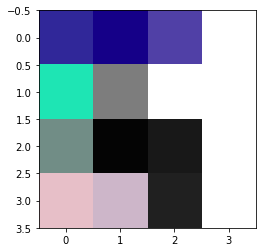

Number of white pix: 5
Image saved since below threshold


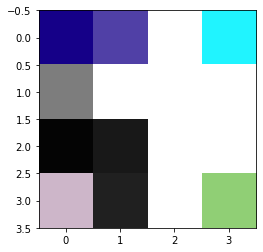

Number of white pix: 7
Image saved since below threshold


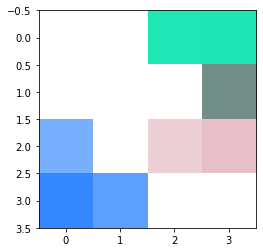

Number of white pix: 8


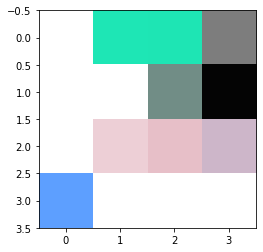

Number of white pix: 7
Image saved since below threshold


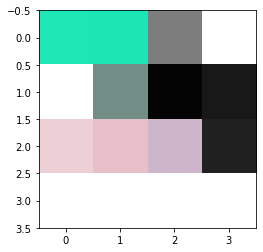

Number of white pix: 6
Image saved since below threshold


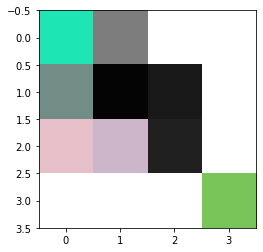

Number of white pix: 7
Image saved since below threshold


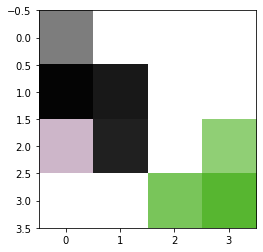

Number of white pix: 8


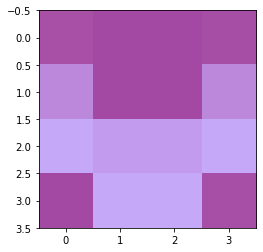

Number of white pix: 0
Image saved since below threshold


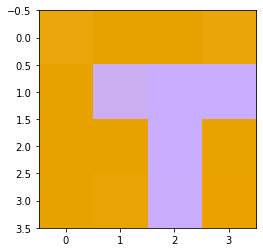

Number of white pix: 0
Image saved since below threshold


In [2]:

img= cv2.imread(bop)
img_shape= img.shape
global X,Y
#X,Y are the image dimensions
Y,X = img_shape[0],img_shape[1]
#x,y are the additions to make it divisible by the tile
y=math.ceil(Y/Tilesize[0])*Tilesize[0]-Y
x=math.ceil(X/Tilesize[1])*Tilesize[1]-X

plt.imshow(img)
plt.show()

for i in range(3):
    for j in range(5):
        trainimg=img[i:i+4,j:j+4]
        result = np.count_nonzero(np.all(trainimg==NDV,axis=2))
        plt.imshow(trainimg)
        plt.show()
        print('Number of white pix: '+str(result))
        if result <Threshold_white:
            tile_name="train{},{}_{}".format(str(i),str(j),'bop')
            img_path=Top_dir + '\\Training_bop\\' +tile_name+ ".png"
            cv2.imwrite(img_path, trainimg)
            print('Image saved since below threshold')

val_img = img[6:10,0:4]
result = np.count_nonzero(np.all(val_img==NDV,axis=2))
plt.imshow(val_img)
plt.show()
print('Number of white pix: '+str(result))
if result <Threshold_white:
    tile_name="val{},{}_{}".format(str(i),str(j),'bop')
    img_path=Top_dir + '\\Validation_bop\\' +tile_name+ ".png"
    cv2.imwrite(img_path, val_img)
    print('Image saved since below threshold')

test_img = img[6:10,4:8]
result = np.count_nonzero(np.all(test_img==NDV,axis=2))
plt.imshow(test_img)
plt.show()
print('Number of white pix: '+str(result))
if result <Threshold_white:
    tile_name="test{},{}_{}".format(str(i),str(j),'bop')
    img_path=Top_dir + '\\Test_bop\\' +tile_name+ ".png"
    cv2.imwrite(img_path, test_img)
    print('Image saved since below threshold')